# PRMT-2321 Increase in EMIS-EMIS not LM compliant in July - is this within a small number of practices?

## Context
In the month of July we have seen a spike in EMIS-EMIS error code 23 - Sender not LM compliant. This is unexpected as EMIS is Large message compliant overall. Feedback from EMIS support said that Large messaging is configurable at a practice level and needs to be enabled.

## Scope
Are these across many practices or across a small group?

If a small group, is there anything special about these practices, e.g. can we see if they are a practice that recently migrated from another supplier system?

## Hypothesis 
A small group of practices make up the majority of EMIS-EMIS not LM compliant errors.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Load June and July 2021 data

In [2]:
transfer_file_location = "s3://prm-gp2gp-transfer-data-preprod/v4/"
transfer_files = [
    "2021/6/transfers.parquet",
    "2021/7/transfers.parquet"    
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))
transfers = transfers_raw.copy()

In [3]:
asid_lookup_file_location = "s3://prm-gp2gp-asid-lookup-preprod/"
asid_lookup_files = [
    "2021/7/asidLookup.csv.gz",
    "2021/8/asidLookup.csv.gz"    
]
asid_lookup_input_files = [asid_lookup_file_location + f for f in asid_lookup_files]
asid_lookup = pd.concat((
    pd.read_csv(f)
    for f in asid_lookup_input_files
)).drop_duplicates()
lookup = asid_lookup[["ASID", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code','OrgName':'requesting_practice_name'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code','OrgName':'sending_practice_name'}, axis=1)

### EMIS - EMIS: Sender not Large Message compliant (error 23)

In [4]:
emis_sender_bool = transfers["sending_supplier"]=="EMIS"
emis_requester_bool = transfers["requesting_supplier"]=="EMIS"
sender_error_23_bool = transfers["sender_error_codes"].apply(lambda error_codes: 23 in error_codes)
emis_transfers_with_error_23 = transfers[emis_sender_bool & emis_requester_bool & sender_error_23_bool].copy()

grouped_emis_transfers_with_error_23 = emis_transfers_with_error_23.groupby(by='sending_practice_name').agg({'conversation_id': 'count'}).sort_values(by='conversation_id', ascending=False).reset_index()

In [5]:
grouped_emis_transfers_with_error_23

,sending_practice_name,conversation_id
0,ST CLEMENTS PARTNERSHIP,3
1,ARCHWAY MEDICAL CENTRE,3
2,GODIVA GROUP PRACTICE,2
3,UNIVERSITY HEALTH SERVICE,2
4,CLARENCE MEDICAL CENTRE,2
...,...,...
240,HIGH STREET SURGERY,1
241,HIGHERLAND SURGERY,1
242,HOLLIES MEDICAL CENTRE,1
243,HOLLYMOOR MEDICAL CENTRE,1


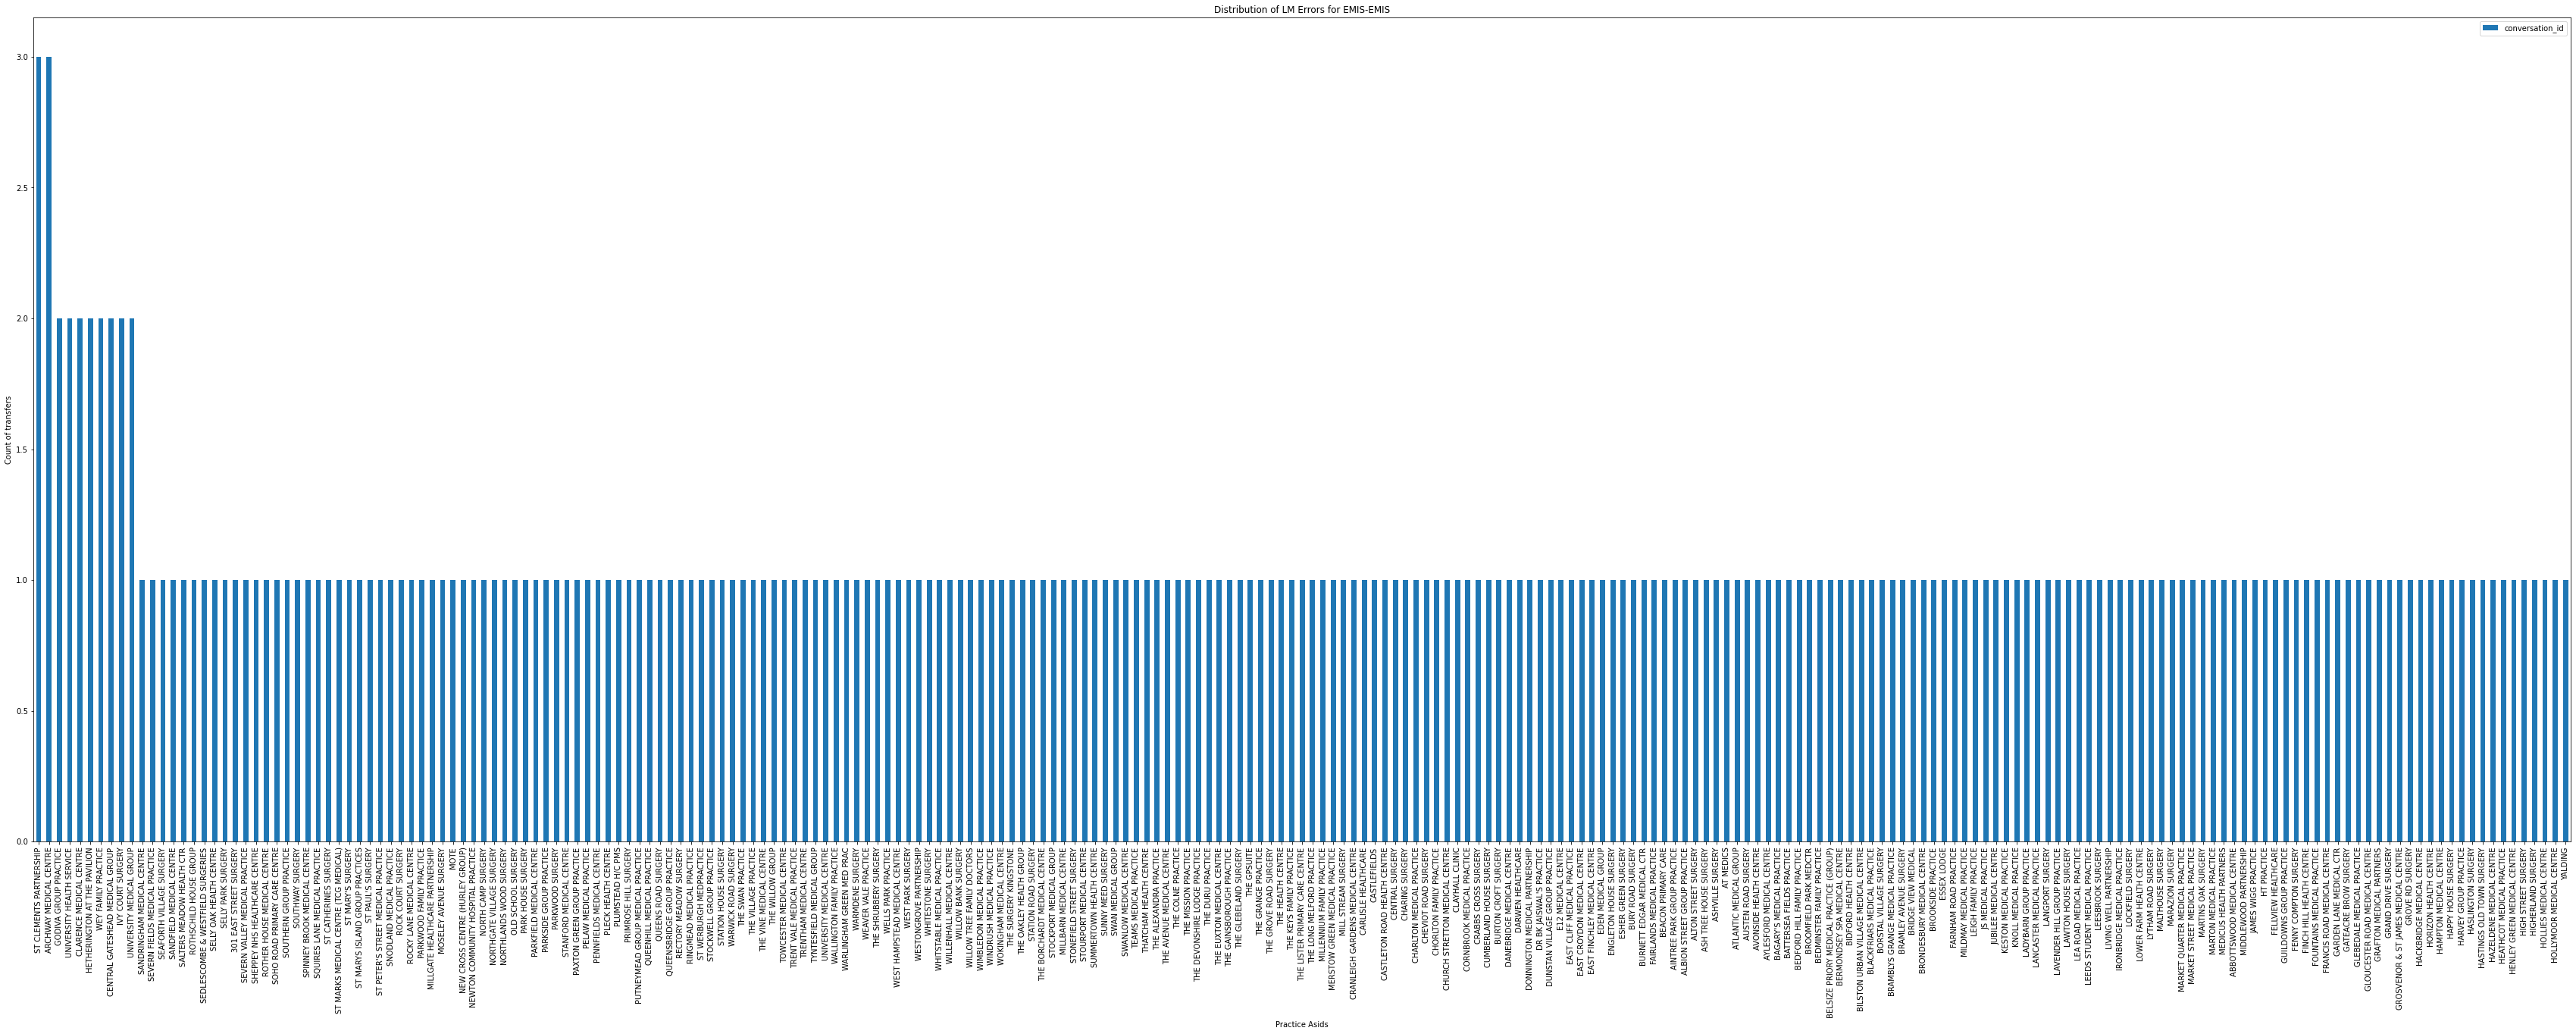

In [6]:
grouped_emis_transfers_with_error_23.plot.bar(x='sending_practice_name', y='conversation_id', xlabel="Practice Asids", ylabel="Count of transfers", title="Distribution of LM Errors for EMIS-EMIS", figsize=(60,20))
grouped_emis_transfers_with_error_23_plot = plt.xticks(rotation='vertical')

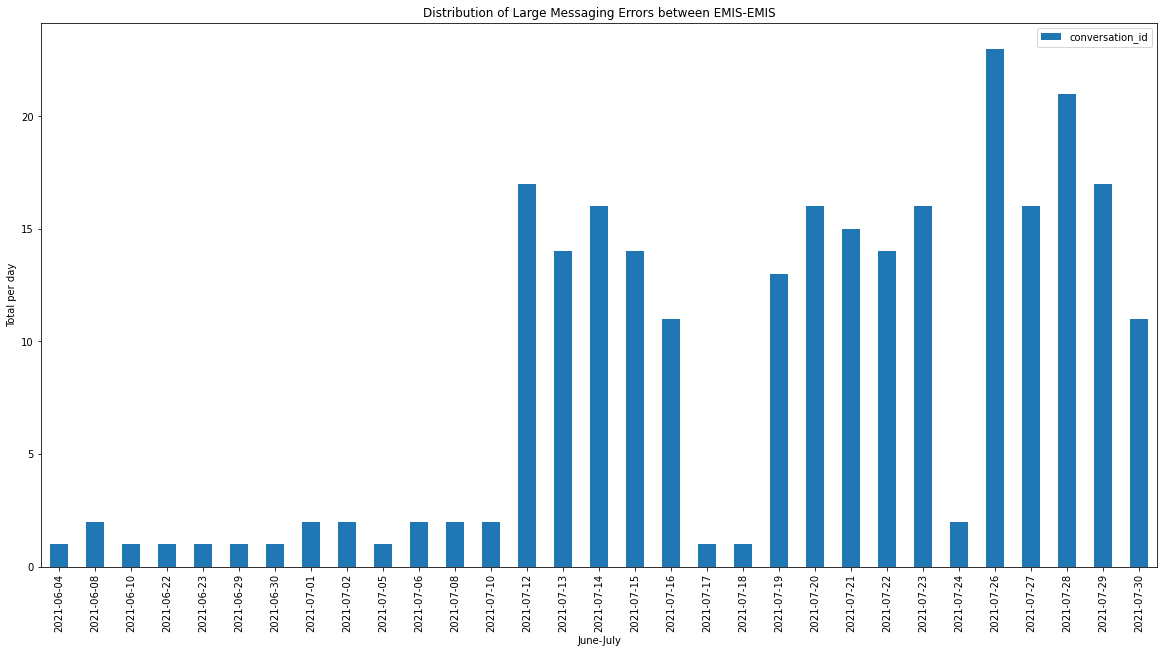

In [7]:
emis_transfers_with_error_23["date"] = emis_transfers_with_error_23["date_requested"].dt.date

emis_transfers_with_error_23_grouped_by_date = emis_transfers_with_error_23.groupby(by="date").agg({"conversation_id": "count"}).reset_index()
emis_transfers_with_error_23_grouped_by_date.plot.bar(x='date', y='conversation_id', xlabel='June-July', ylabel='Total per day', title="Distribution of Large Messaging Errors between EMIS-EMIS", figsize=(20,10))

emis_transfers_with_error_23_grouped_by_date_plot = plt.xticks(rotation='vertical')